# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 004


### Due: October 20, 2020

#### Problem

a) You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your testing data to decide when to stop training if appropriate. Use your validation set to compute the accuracy of you classfier. 

In [1]:
# NN = MLP()
# NN.add_layer('Hidden', dim_in=2, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Output', dim_in=16, dim_out=3)
# NN.add_layer('Loss', dim_in=3, dim_out=3)

# loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
# plot_loss(loss)
# plot_decision_regions(NN)

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Copying grading checklist below

Hi all, here is a check list(rough rubric) for HW3.
This is pretty much the same as what questions asked. You might want to check all those below
before submit your HW.

a)  60 points
Will be focusing on whether you satisfied all required conditions when building and training your network. Points will be (roughly) evenly allocated to the following conditions.
1. If you implemented each (hidden, output, loss) layer type as separate classes and had all mentioned functions for each class.
2. If you Implement a MLP class with all mentioned functions.
3. If you used the required activation function.
4. If you used softmax.
5. If loss is correctly computed.
6. Layers’ dimensions are properly passed as required.
7. Training parameters are properly passed as required.
8. If you used regularization in a correct way
9. Run the network using the same or similar code given in the notebook.

b) 5 points
1. If you densely generated points for the whole plane in a proper way.
2. If you colored the points in a correct way

c) 15 points
If you tried all required parameters and plotted the decision region for each.

d) 20 points
1. If you separated your data
2. If you implemented early stopping correctly
3. If you computed accuracy

It could be changed a bit during grading, but not much. There will be deduction in points if the results are not as expected.
In HW2, there were many students implemented models correct but not trained it enough.  Try to use matrices in minibatch calculations(not calculating individual samples using for loop). Then it will take not too long to train more epochs.

Let's start by importing some libraries.

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [3]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,0.985871,-0.569780,0.0
1,-0.193917,-1.415474,2.0
2,-0.371079,-1.297821,2.0
3,-0.455777,1.193866,0.0
4,-1.504097,-0.766154,1.0


Let's message this data into a numpy format.

In [4]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [5]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

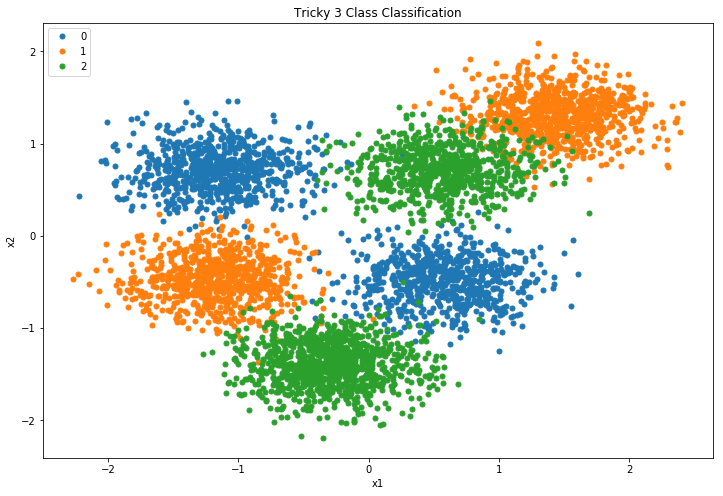

In [6]:
plot_data(X, y)

Now build your network. Good luck! 😉 

This is for plotting dense sample later. Basically will change `y` into something like `[0, 1, 2, 1, 2, 0]`, i.e. from shape `(5000, 1)` to `(5000,)`.

In [7]:
y_int_labels = np.array(y.flatten(), dtype='int32')[0]
assert y_int_labels.shape == (5000,)

Change `X` and `y` into `ndarray` and do sanity check

In [8]:
X = np.array(X)
y = np.array(y)

assert X.shape == (5000, 2)
print(X[0:3])

assert y.shape == (5000, 1)
print(y[0:3])

[[ 0.98587073 -0.56978023]
 [-0.19391706 -1.4154743 ]
 [-0.37107908 -1.29782093]]
[[0.]
 [2.]
 [2.]]


Apply `one hot encoding` to `y`, check if the encoding is correct by comparing the `one-hot-encoded y`to the `y` printed above

In [9]:
data = np.array(y.flatten(), dtype='int32')
shape = (data.size, int(data.max() + 1))

y = np.zeros(shape)
rows = np.arange(data.size)

y[rows, data] = 1.0

assert y.shape == (5000, 3)
print(y[0:3])

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### a) Implement MLP

#### a.1 Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

First, create a base class `Layer`

In [10]:
# Use Abstract Base Class from Python standard lib
from abc import ABC, abstractmethod
 
class Layer(ABC):
    
    # Some initializations for Layer:
    # 1. Assign dimensions (dim_in, dim_out)
    # 2. Assign weight_init strategy
    def __init__(self, name, dim_in=None, dim_out=None, weight_init='standard', debug=False):
        self.name = name
        
        self.dim_in = dim_in
        self.dim_out = dim_out
     
        if isinstance(self, Input) or isinstance(self, Hidden) or isinstance(self, Output):
            self.weight_init = weight_init
            self.init_weights()
            
        self.debug = debug
        
    # Initialize weights using weight_init strategy
    def init_weights(self):
        init_method = self.weight_init.lower()
        
        # Here I only implement one strategy, using Standard Normal distribution
        if init_method == 'standard':
            self.W = np.random.normal(0, 1, self.dim_in*self.dim_out).reshape(self.dim_in, self.dim_out)
            
        else:
            raise Exception('Non-supported initialization method')
            
        # For bias, simply set to zeros
        self.b = np.zeros(self.dim_out, dtype='float32')
    
    # Abstract forward method for Layer, 
    # taking both inputs X and y to calculate activation/loss
    @abstractmethod
    def forward_propagate(self, X, y):
        # To be implemented in the child class
        pass
    
    # Abstract back propagate method for Layer, 
    # taking grads from previous layer
    @abstractmethod
    def back_propagate(self, grads, regularizer=None):
        # To be implemented in the child class
        pass

Second, create a `Linear` `Layer`, i.e. simply a feedforward `Layer`

In [11]:
class Linear(Layer):
    
    # Parent initialization
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
    
    # W is param weight and b is intercept/bias
    def forward_propagate(self, X, y=None):
        # Simply save the input 
        self.X = X
        
        # and return the WX + b value
        return np.dot(X, self.W) + self.b
    
    # Compute grads for both W and b
    def back_propagate(self, grads, regularizer=None):
        # For W, we do matrix multiplication between our input X
        # and the gradients from previous layer and then take 
        # the average over the resulting columns, i.e. axis=0
        # The tricky thing here is that we have to match the shape to be able
        # to do the multiplication. For X, we add newaxis as the third dimension
        # meanwhile for the grads, we add it as the second dimension
        self.grad_W = (np.matmul(self.X[:, :, np.newaxis], grads[:, np.newaxis,:])).mean(axis=0)
        
        # Add regularization update if used
        if regularizer != None:
            self.grad_W += (regularizer['alpha'] / self.X.shape[0]) * self.W
        
        # For the intercept, we simply take the gradients average
        # We can think of this as having input X equals to vector of 1s,
        # or in numpy something like np.full(shape, 1.0),
        # which if we multiply with our grads will result in the grads itself
        self.grad_b = grads.mean(axis=0)
        
        # The gradients to be passed to the next (or prev I should say) layer
        # is computed by taking dot product of the current gradients 
        # and this layer weights
        return np.dot(grads, self.W.transpose())

Third, create class for `Input`, `Hidden` layer and `Output` `Layer`

All the three classes are basically the same since I already create a `Linear` `Layer` as their parent. But, for the sake of the assignment requirement, which is to have separate classes for each `Layer`, then I implement them as below

In [12]:
class Input(Linear):
    
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
        
class Hidden(Linear):

    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)

class Output(Linear):
    
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)

Now, we're done with all the feedforward `Layer`

Next, let's implement the `Activation` and `Loss` class, which are also the child of the base class `Layer`.

In [13]:
# For Activation, I cover two types: ReLU and Softmax
class Activation(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    def apply_relu(self): 
        # For ReLU, need to keep X original values
        # for backpropagation later
        self.X_linear = np.copy(self.X)
        
        # Clip all negative values to zero
        return np.clip(self.X, 0, None)
    
    def apply_leaky_relu(self, leaky_alpha=0.3):
        self.leaky_alpha = leaky_alpha
        
        # For Leaky ReLU, need to keep X original values
        # for backpropagation later
        self.X_linear = np.copy(self.X)
        
        return np.where(self.X > 0, self.X, leaky_alpha * self.X)
    
    def apply_softmax(self):
        # Simply use the formula (e^x / sum(e^x)), but to make the 
        # computation stable (e.g. no overflow from exp operation), 
        # we need to reduce each element with the max over the row, i.e. axis=1
        # Also, the tricky thing here is that we need to duplicate the max value
        # (n_classes) time so that we can perform subtraction
        X_max = np.repeat(np.max(self.X, axis=1), self.X.shape[1]).reshape(self.X.shape[0], self.X.shape[1])
        Z = np.subtract(self.X, X_max)
        
        # Another tricky thing here is we need to expand the dimension
        # so it's easier later to backpropagate
        # Save these values as well for later backpropagation
        self.y_probs = np.exp(Z) / np.exp(Z).sum(axis=1)[:, np.newaxis]

        return self.y_probs
    
    def compute_relu_derivative(self, grads, regularizer=None):
        # Simply replace all positive values to the received grads
        return np.where(self.X_linear > 0, grads, 0)
    
    def compute_leaky_relu_derivative(self, grads, regularizer=None):
        dx = np.ones_like(self.X_linear)
        
        dx[self.X_linear < 0] = self.leaky_alpha
        
        return grads * dx
    
    def compute_softmax_derivative(self, grads, regularizer=None):
        # Again, expand the dimension for the sake of the backpropagation
        return self.y_probs * (grads - (grads * self.y_probs).sum(axis=1)[:, np.newaxis])

    # Wrapper for activations, i.e. choosing actions based on param
    def activate(self):
        if 'leaky_relu' in self.name:
            activation_func = self.apply_leaky_relu
            
        elif 'relu' in self.name: 
            activation_func = self.apply_relu
            
        elif 'softmax' in self.name:
            activation_func = self.apply_softmax
        
        else:
            raise Exception('Non-supported activation function')
            
        return activation_func()
    
    # Forward action for Activation layer is simply
    # calling the activation function, thus y is unneeded
    def forward_propagate(self, X, y=None):
        self.X = X
        
        return self.activate()
    
    # Backpropagation action for Activation layer
    # is computing the derivative/gradients
    def back_propagate(self, grads, regularizer=None):
        if 'leaky_relu' in self.name:
            derivative_func = self.compute_leaky_relu_derivative
            
        elif 'relu' in self.name:
            derivative_func = self.compute_relu_derivative
            
        elif 'softmax' in self.name:
            derivative_func = self.compute_softmax_derivative
        
        else:
            raise Exception('Non-supported activation function')
        
        return derivative_func(grads, regularizer=regularizer)

# For Loss, I cover only Cross Entropy loss
class Loss(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    # X has shape of (num_examples, num_classes)
    # y has shape of (num_examples,)
    # IMPORTANT: y needs to be ONE-HOT ENCODED 
    # IMPORTANT: APPLY SOFTMAX to X beforehand
    def apply_cross_entropy(self):
        n_examples = self.X.shape[0]
        
        return (1/n_examples)*(np.where(self.y==1.0, -np.log(self.X), 0.0)).sum(axis=1)  
    
    def apply_L2_loss(self):
        reg_loss = 0.0
        n_examples = self.X.shape[0]
        n_layers = len(self.layer_W)
        
        # Sum L2 loss over all layer weights
        for W in self.layer_W:
            reg_loss = reg_loss + np.sum(np.square(W))
        
        # Divide total L2 loss by 2*n_examples, amplify by alpha
        return (self.alpha/(2*n_examples)) * reg_loss
    
    # Wrapper for losses, i.e. choosing actions based on param
    def compute_loss(self):
        if self.debug:
            print('y_out shape: {}'.format(y_out.shape))
            print('y shape: {}'.format(y.shape))
            
        if 'cross_entropy' in self.name:
            loss_func = self.apply_cross_entropy
            
        else:
            raise Exception('Non-supported loss function')
        
        loss = loss_func()
        
        # Add regularization loss if specified
        if self.reg_type != None:
            loss = loss + self.compute_regularization_loss()
        
        return loss
    
    # Wrapper for regularization losses, i.e. choosing actions based on param
    def compute_regularization_loss(self):
        if self.reg_type == 'L2':
            reg_loss = self.apply_L2_loss()
            
        else:
            raise Exception('Non-supported regularization type')
            
        return reg_loss
    
    # Forward action for Loss layer is computing the loss,
    # thus the true label y is needed
    def forward_propagate(self, X, y, regularizer):
        self.X = X
        self.y = y
        
        self.reg_type = None
        
        if regularizer != None:
            self.reg_type = regularizer['reg_type']
            self.alpha = regularizer['alpha']
            self.layer_W = regularizer['layer_W']
        
        return self.compute_loss()
    
    # Backpropagation action for Loss layer is computing the 
    # derivative/gradients given the classification mismatch
    # In this case, for Cross Entropy, we set the derivation
    # value to (-1/X), which is the derivative of natural log
    # We do that for all the indexes where the true label lies
    # Remember we do one hot encoding, so there are only 0s and 1
    def back_propagate(self, grads=None, regularizer=None):    
        return np.where(self.y==1.0, -1/self.X, 0.0)

# A function to check if the above implementation is correct
def check_activation_and_loss_imp():
    y_out = np.array([1.0, -2.0, 3.0, -5.0])
    
    reluAct = Activation('relu_0')
    assert (reluAct.forward_propagate(y_out) == np.array([1., 0., 3., 0])).all()
    
    y_out = np.array([[1.0, 2.0, 3.0], [2.0, 2.0, 2.0]])
    
    softmaxAct = Activation('softmax_0', False)
    y_out_softmax = softmaxAct.forward_propagate(y_out)

    print(np.sum(y_out_softmax, axis=1))
    
    crossEntropyLoss = Loss('cross_entropy_0')
    print(crossEntropyLoss.forward_propagate(y_out_softmax, np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]]), None))

Sanity checks to see if `Activation` and `Loss` implementation is correct:

In [14]:
check_activation_and_loss_imp()

[1. 1.]
[1.20380298 0.54930614]


#### a.2 Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction.

Finally, an `MLP` class

In [15]:
import copy

class MLP():
    
    # Initialize Layers placeholder
    def __init__(self, debug=True):
        self.layers = []
        
        self.debug = debug
        
    # Let the layer type (there is 5), dimensions (in and out) and 
    # weight initialization strategy be parameters passed when adding a layer
    def add_layer(self, layer_type, dim_in=None, dim_out=None, weight_init='standard'):
        layer_type = layer_type.lower()
        
        num_of_layers = sum(layer_type in layer.name for layer in self.layers)
        
        # The layer names would be something like: input_0, relu_0, 
        # hidden_0, relu_1, output_0, softmax_0, loss_0
        name = layer_type + '_' + str(num_of_layers)
        
        if layer_type == 'input':
            self.layers.append(Input(name, dim_in, dim_out, weight_init))
            
        elif layer_type == 'hidden':
            self.layers.append(Hidden(name, dim_in, dim_out, weight_init))
        
        elif layer_type == 'output':
            self.layers.append(Output(name, dim_in, dim_out, weight_init))
            
        elif 'activation' in layer_type:
            self.layers.append(Activation(name))
            
        elif 'loss' in layer_type:
            self.layers.append(Loss(name))
        
        else:
            raise Exception('Non-supported layer type')
    
    # Basically calling forward_propagate from all layers
    # Set include_loss to True for training because 
    # we need it to compute the gradients
    # Set include_loss to False for prediction because
    # we only need the Softmax probabilities output
    def forward_propagate(self, X, y, include_loss, regularizer):
        if self.debug:
            print('Forward propagating...')
            print('Input shape: {}'.format(X.shape))
        
        for layer in self.layers:
            if self.debug:
                print('Layer name: {}'.format(layer.name))
                    
            if not isinstance(layer, Loss):

                X = layer.forward_propagate(X)

                if self.debug:
                    print('Output shape: {}'.format(X.shape))
                    
            else:
                if include_loss:
                    loss = layer.forward_propagate(X, y, regularizer)

                    if self.debug:
                        print('Loss shape: {}'.format(loss.shape))
                        
        if include_loss:
            return loss 
        else:
            return X
    
    # Basically calling back_propagate from all layers
    # See that we chain the grads here by passing computed grads from
    # the current layer to the next (or should I say previous) layer
    def back_propagate(self, regularizer=None):
        if self.debug:
            print('Back propagating...')
            
        grads = None
        
        for layer in reversed(self.layers):
            if self.debug:
                print('Layer name: {}'.format(layer.name))
            
            grads = layer.back_propagate(grads, regularizer=regularizer)

            if self.debug:
                print('Grads shape: {}'.format(grads.shape))
    
    # Update the weights using the computed grads/derivaties 
    # and the input learning_rate
    # Note that we only update for Linear layers here
    def update_weights(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W = layer.W - learning_rate * layer.grad_W
                layer.b = layer.b - learning_rate * layer.grad_b
    
    # Main training routine
    # Let the number of training epochs, the mini-batch size, and the 
    # regularization parameter be parameters that are passed when 
    # training the network.
    def train(self, X, y, learning_rate, epochs, bsize, regularizer, X_val=None, y_val=None, early_stopping=-1):
        # IMPORTANT: I enforce that the last layer should be a Loss layer
        if not isinstance(self.layers[len(self.layers) - 1], Loss):
            raise Exception('Last layer is not a Loss layer')
        
        # Loss placeholder with size equals to epochs
        losses = []
        
        if len(X_val) > 0 and len(y_val) > 0:
            use_val = True
        else:
            use_val = False
        
        # Val loss placeholder if X_val and y_val is provided
        if use_val:
            val_losses = []
        
        # Set up variables related to early stopping
        # Early stopping = -1 means that we don't use early stopping
        # meanwhile any early stopping > 0 means that we stop the training
        # if the validation loss doesn't improve for early_stopping epochs
        # It is considered stagnant if for early_stopping epochs, it is 
        # still greater than the current/latest minimum validation loss
        # recorded so far
        if early_stopping > 0:
            min_avg_loss = 10
            bigger_than_min_count = 0
            
            # Make NN copy so we can retrieve the weights associated
            # with the latest minimum val loss later after training
            min_NN = copy.deepcopy(self)
        
        # Loop over epochs
        for i in range(0, epochs):
            # Reset loss and start index for every epoch
            # idx_start is used to implement mini batch scenario
            loss = 0.0
            idx_start = 0
            
            # Iterate for all minibatches
            while idx_start < X.shape[0]:
                # A minibatch is defined by [idx_start:idx_end]
                idx_end = idx_start + bsize
                
                # For the last batch, if idx_end is greater
                # than the number of samples, then clip it
                if idx_end > X.shape[0]:
                    idx_end = X.shape[0]
                
                # Get minibatch
                X_minbatch, y_minbatch = X[idx_start:idx_end], y[idx_start:idx_end]
                
                # If regularizer is used, we need to pass every layer weights
                # to the Loss layer to compute regularization loss
                if regularizer != None:
                    regularizer['layer_W'] = []
                    
                    for layer in self.layers:
                        if isinstance(layer, Linear):
                            regularizer['layer_W'].append(layer.W)
 
                # Sum the loss cumulatively for every batch
                # Here, we call forward_propagate to do that   
                loss = loss + self.forward_propagate(X_minbatch, y_minbatch, include_loss=True, regularizer=regularizer).sum()
            
                # Call back_propagate to compute and set the gradients,
                # both for W and b for each layer
                # Include regularizer to update the weights if any
                self.back_propagate(regularizer=regularizer)
                
                # Update weights, only for Linear layer
                self.update_weights(learning_rate)
                        
                # Adjust idx_start for next minibacth
                idx_start = idx_start + bsize
            
            # Save average loss for current epoch
            avg_loss = loss / X.shape[0]
            losses.append(avg_loss)
            
            if use_val:
                # Compute val_loss the same way as computing loss but feeds X_val and y_val instead
                val_loss = self.forward_propagate(X_val, y_val, include_loss=True, regularizer=regularizer).sum()
                avg_val_loss = val_loss / X_val.shape[0]
                
                if early_stopping > 0:
                    # Need to update when we find new minimum validation loss
                    if avg_val_loss < min_avg_loss:
                        # Update min_avg_loss
                        min_avg_loss = avg_val_loss
                        
                        # Record new weights
                        min_NN = copy.deepcopy(self)
                        
                        # Reset count
                        bigger_than_min_count = 0

                    else:
                        # Otherwise, increment count
                        bigger_than_min_count += 1

                val_losses.append(avg_val_loss)
                
                if (i+1) % 10 == 0:
                    print('Epoch: {}, Average Training Loss: {}, Average Validation Loss: {}'.format(i+1, avg_loss, avg_val_loss))
            else:
                # Print info every 10 iterations
                if (i+1) % 10 == 0:
                    print('Epoch: {}, Average Training Loss: {}'.format(i+1, avg_loss))
            
            # Check for early stopping condition
            if use_val and early_stopping > 0:
                if bigger_than_min_count > early_stopping:
                    print('Early stopping at epochs: {}'.format(i+1))
                    i = epochs + 1
                    break
        
        # Return as needed, e.g. return min_NN when using early stopping
        # and return val losses when if X_val and y_val are provided 
        if use_val:
            if early_stopping > 0:
                return min_NN, np.array(losses), np.array(val_losses)
            else:
                return np.array(losses), np.array(val_losses)
            
        else: 
            # Only return loss if no X_val and y_val are provided 
            return np.array(losses)
    
    # Predict return arrays of label, i.e. [0, 2, 1, 0, 2]
    # given input X (2D)
    def predict(self, X):
        # Get Softmax probabilities through forward propagation
        y_out_probs = self.forward_propagate(X, None, include_loss=False, regularizer=None)
        
        # For each sample, i.e. each row, take the index
        # which has maximum probability, denoting the label
        return np.argmax(y_out_probs, axis=1)
    
    # Additional function to compute accuracy
    def compute_accuracy(self, X, y):
        y_true_labels = np.argmax(y, axis=1)
        y_preds = self.predict(X)
        
        verdict = [1 if y1 == y2 else 0 for y1, y2 in zip(y_true_labels, y_preds)]

        return np.sum(verdict) / len(verdict)

#### a.3 Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

Build our `MLP`, train it and get the losses. `LEARNING_RATE = 0.01` (that is the same as `Keras` default) and `BSIZE=256`, I find that `BSIZE=8` is unnecessary since it is longer to train and using `BSIZE=256` doesn't greatly reduce performance. Thus, for every epoch, there will be ~`20` minibatches. `EPOCHS` is set to `100`.

In [16]:
feature_size, n_classes = (2, 3)

# Use 2 Hidden Layers with 8 Hidden Units each
n_hidden_layers, n_hidden_units = (2, 8)

NN = MLP(debug=False)

# Input Layer of shape (2, 8) with 2 as dim_in being the size of feature
NN.add_layer('Input', dim_in=feature_size, dim_out=n_hidden_units)
# Use ReLU activation for Input Layer
NN.add_layer('Activation_Relu')

for _ in range(0, n_hidden_layers):
    # Hidden Layer of shape (8, 8) with 3 being the number of hidden units
    NN.add_layer('Hidden', dim_in=n_hidden_units, dim_out=n_hidden_units)
    # Also use ReLU activation for Hidden Layer
    NN.add_layer('Activation_Relu')

# Output Layer of shape (8, 3) with 3 as dim_out being the number of classes
NN.add_layer('Output', dim_in=n_hidden_units, dim_out=n_classes)
# Use Softmax activation to get smooth class probabilities
NN.add_layer('Activation_Softmax')

# Cross Entropy Loss Layer to compute the loss based on Softmax activations
NN.add_layer('Loss_Cross_Entropy')

# Finally, train the NN and fetch the losses
print('No regularizer is used')
print('---------------------------------')

print('Training for {} hidden layer(s) and {} hidden units'.format(n_hidden_layers, n_hidden_units))
print('---------------------------------')

# LEARNING_RATE = 0.01 (also Keras default) and BSIZE=256, I find that BSIZE=8 is too long to train
# And using BSIZE=256 doesn't greatly reduce performance
# Thus, for every epoch, there will be ~20 minibatches
# EPOCHS is set to 100, pretty standard
losses = NN.train(X, y, learning_rate=0.01, epochs=100, bsize=256, regularizer=None, X_val=[], y_val=[])

No regularizer is used
---------------------------------
Training for 2 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.001164133178479252
Epoch: 20, Average Training Loss: 0.0009442900879744311
Epoch: 30, Average Training Loss: 0.0008205328128197427
Epoch: 40, Average Training Loss: 0.0007383415051360142
Epoch: 50, Average Training Loss: 0.0006795683416732025
Epoch: 60, Average Training Loss: 0.000633736433867131
Epoch: 70, Average Training Loss: 0.000596345016848684
Epoch: 80, Average Training Loss: 0.0005641591233974401
Epoch: 90, Average Training Loss: 0.0005365479800565544
Epoch: 100, Average Training Loss: 0.0005126989115423391


Plot the losses for 100 epochs

In [17]:
def plot_losses(errors, title):
    n_iters = len(errors)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.plot(np.arange(1, n_iters + 1, 1), errors, label='Training Loss')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Loss')
    
    ax.set_title(title)
    
    plt.show()

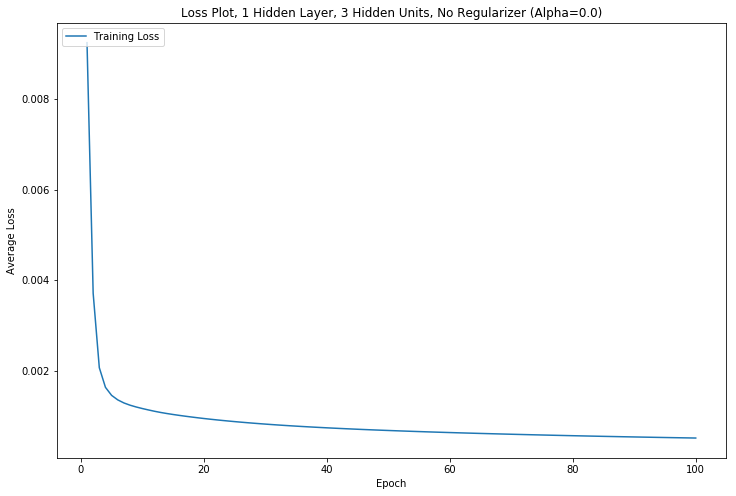

In [18]:
plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(1, 3, 0.0))

### b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels.

The code below is the same code that I used for HW2

In [19]:
# Generate 2D dense data for decision boundary
# The dense samples are square in shape, so x1_low == x2_low and x1_high == x2_high
def generate_dense_data_2d(network, low, high, step):
    # How many dots are within one line, either vertically and horizontally
    reps = int((high - low) / step) + 1
    
    # Generate different x1s using np.arange
    x1 = np.arange(low, high + step, step)
    # Repeat, so we get something like: [-0.5, -0.5, -0.5, -0.4, -0.4, -0.4, ...]
    x1 = np.repeat(x1, reps)
    
    # Generate different x2s using np.arange, but the value is actually the same as x1s
    x2 = np.arange(low, high + step, step)
    # Make a tile, so we get something like: [-0.5, -0.4, -0.3, -0.5, -0.4, -0.3, ...]
    x2 = np.tile(x2, reps)
    
    # Set a placeholder of size reps squared
    n_data = reps ** 2
    dense_data = pd.DataFrame(np.zeros((n_data, 3)), columns=['x1', 'x2', 'y'])

    # Assign x1s and x2s to the placeholder, each as separate series
    dense_data.iloc[:, 0] = x1
    dense_data.iloc[:, 1] = x2
   
    # Create np.matrix of X feature to be feed to the network
    # then convert it to np.array
    X = np.array(np.matrix(dense_data.iloc[:, 0:2].values))

    # Get probability distribution of label y given X
    y = network.predict(X)
    
    # Assign ys to the placeholder
    dense_data.iloc[:, 2] = y
    
    return dense_data

# Convert from DataFrame to Numpy and do sanity check
def convert_to_numpy(data):
    # set X (training data) and y (target variable)
    cols = data.shape[1]
    X = data.iloc[:, 0:cols-1]
    y = data.iloc[:, cols-1:cols]

    # The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
    X = np.matrix(X.values)
    y = np.matrix(y.values)
    
    return X, y

# Convert from DataFrame to Numpy and do sanity check
def convert_and_check_data(data, n_data, dim):
    X, y = convert_to_numpy(data)

    y_modified = y.flatten()
    y_modified = np.array(y_modified)[0]

    assert X.shape == (n_data, dim)
    assert y_modified.shape == (n_data,)
    
    return X, y_modified

# Modify plot data to enable plotting overlay
def plot_data_overlay(X, y, X_dense, y_dense, title, colorset):
    c0, c1, c2, c0_dense, c1_dense, c2_dense = colorset[0], colorset[1], colorset[2], colorset[3], colorset[4], colorset[5]
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    indices_0_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 0]
    indices_1_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 1]
    indices_2_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 2]
    
    ax.plot(X_dense[indices_0_dense, 0], X_dense[indices_0_dense, 1], color=c0_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_1_dense, 0], X_dense[indices_1_dense, 1], color=c1_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_2_dense, 0], X_dense[indices_2_dense, 1], color=c2_dense, marker='o', linestyle='', ms=5)
    
    indices_0 = [k for k in range(0, y.shape[0]) if y[k] == 0]
    indices_1 = [k for k in range(0, y.shape[0]) if y[k] == 1]
    indices_2 = [k for k in range(0, y.shape[0]) if y[k] == 2]
    
    ax.plot(X[indices_0, 0], X[indices_0, 1], color=c0, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=c1, marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2, 1], color=c2, marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_title(title)
    plt.show()

In [20]:
dense_data = generate_dense_data_2d(NN, -3, 3, 1e-2)

dense_X, dense_y = convert_and_check_data(dense_data, 361201, 2)

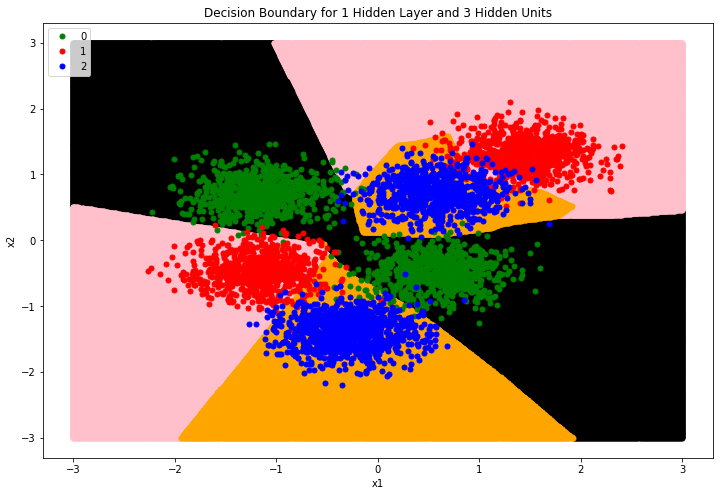

In [21]:
colorset = ['green', 'red', 'blue', 'black', 'pink', 'orange']

plot_data_overlay(X, y_int_labels, dense_X, dense_y, 'Decision Boundary for 1 Hidden Layer and 3 Hidden Units', colorset)

As a note:

1. BLACK regions correspond to GREEN dots, i.e. Class 0
2. PINK regions correspond to RED dots, i.e. Class 1
3. YELLOW regions correspond to BLUE dots, i.e. Class 2

### c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

Build a function to do traning using using a defined scenario, i.e. number of `Hidden Layers`, number of `Hidden Units` and `Regularization Type`, e.g. `L2` and `Regularization Value`, i.e. `alpha`

In [22]:
def do_train(scenario):
    total_scenario = 1
    
    for param in scenario:
        if not isinstance(scenario[param], int):
            total_scenario = total_scenario * len(scenario[param])
        
    print('Total scenario: {}'.format(total_scenario))
    print('---------------------------------')
    print('---------------------------------')
    
    scenario_count = 0
    
    for regularizer in scenario['regularizers']:
        for n_hidden_layers in scenario['n_hidden_layers']:
            for n_hidden_units in scenario['n_hidden_units']:
                scenario_count = scenario_count + 1
                print('Scenario {}'.format(scenario_count))
                print('---------------------------------')
                
                if regularizer is None:
                    print('No regularizer is used')
                    print('---------------------------------')
                    
                else:
                    print('Regularizer is used')
                    print('Regularization type: {}'.format(regularizer['reg_type']))
                    print('Alpha: {}'.format(regularizer['alpha']))
                    print('---------------------------------')
                    
                print('Training for {} hidden layer(s) and {} hidden units'.format(n_hidden_layers, n_hidden_units))
                print('---------------------------------')

                NN = MLP(debug=scenario['debug'])

                NN.add_layer('Input', dim_in=scenario['feature_size'], dim_out=n_hidden_units)
                NN.add_layer('Activation_Relu')

                for i in range(0, n_hidden_layers):
                    NN.add_layer('Hidden', dim_in=n_hidden_units, dim_out=n_hidden_units)
                    NN.add_layer('Activation_Relu')

                NN.add_layer('Output', dim_in=n_hidden_units, dim_out=scenario['n_classes'])
                NN.add_layer('Activation_Softmax')

                NN.add_layer('Loss_Cross_Entropy')

                losses = NN.train(X, y, learning_rate=0.01, epochs=100, bsize=32, regularizer=regularizer, X_val=[], y_val=[])
                
                if regularizer is None:
                    plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(n_hidden_layers, n_hidden_units, 0.0))
                else:
                    plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, {} Regularizer (Alpha={})'.format(n_hidden_layers, n_hidden_units, regularizer['reg_type'], regularizer['alpha']))

                dense_data = generate_dense_data_2d(NN, -3, 3, 1e-2)

                dense_X, dense_y = convert_and_check_data(dense_data, 361201, 2)

                colorset = ['green', 'red', 'blue', 'black', 'pink', 'orange']

                plot_data_overlay(X, y_int_labels, dense_X, dense_y, 'Decision Boundary for {} Hidden Layer and {} Hidden Units'.format(n_hidden_layers, n_hidden_units), colorset)
                
                print('---------------------------------')
                print('---------------------------------')

Train using requested scenario. Note that `regularizer=None` means `alpha=0.0`. I use `L2` loss with two different `alpha`: `0.1` and `1.0`. There are `18` scenarios in total (`2` distinct `Hidden Layers`, 3 distinct `Hidden Units`, 3 different `alpha` values)

Total scenario: 18
---------------------------------
---------------------------------
Scenario 1
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.02314411096985446
Epoch: 20, Average Training Loss: 0.01964225219672112
Epoch: 30, Average Training Loss: 0.012633960206116077
Epoch: 40, Average Training Loss: 0.01124985035505845
Epoch: 50, Average Training Loss: 0.010353351718607724
Epoch: 60, Average Training Loss: 0.009605849924993252
Epoch: 70, Average Training Loss: 0.00901405332416113
Epoch: 80, Average Training Loss: 0.008609897635757034
Epoch: 90, Average Training Loss: 0.008343814121987616
Epoch: 100, Average Training Loss: 0.008172786366797885


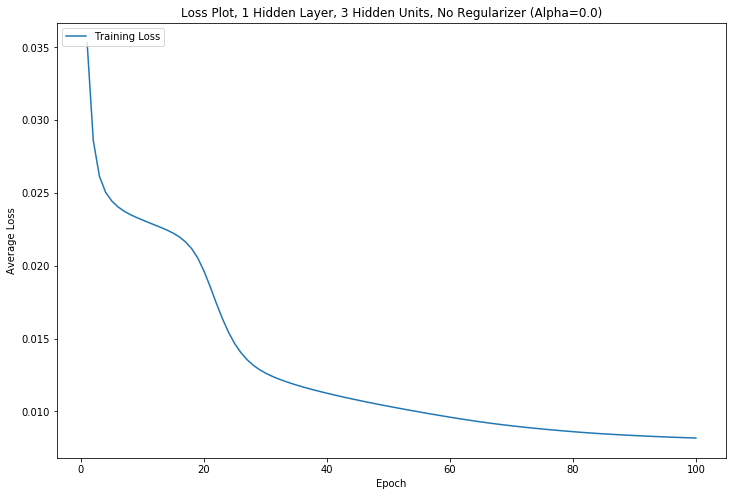

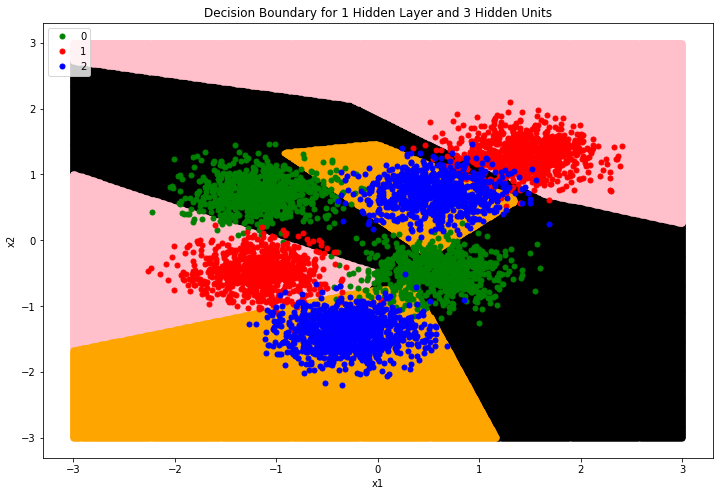

---------------------------------
---------------------------------
Scenario 2
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.005264197219060952
Epoch: 20, Average Training Loss: 0.003633484740630238
Epoch: 30, Average Training Loss: 0.0030831912822203884
Epoch: 40, Average Training Loss: 0.002820747016739563
Epoch: 50, Average Training Loss: 0.002681725991430802
Epoch: 60, Average Training Loss: 0.0026141233683102455
Epoch: 70, Average Training Loss: 0.002580495000817659
Epoch: 80, Average Training Loss: 0.0025565990032663318
Epoch: 90, Average Training Loss: 0.002540762595018506
Epoch: 100, Average Training Loss: 0.0025290694279669337


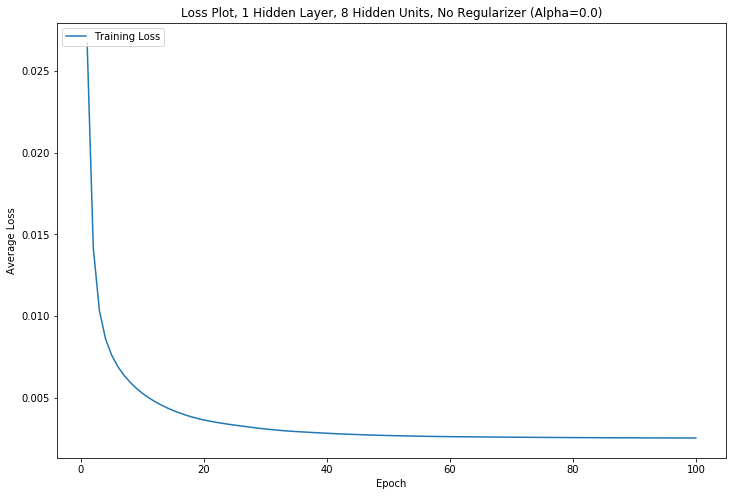

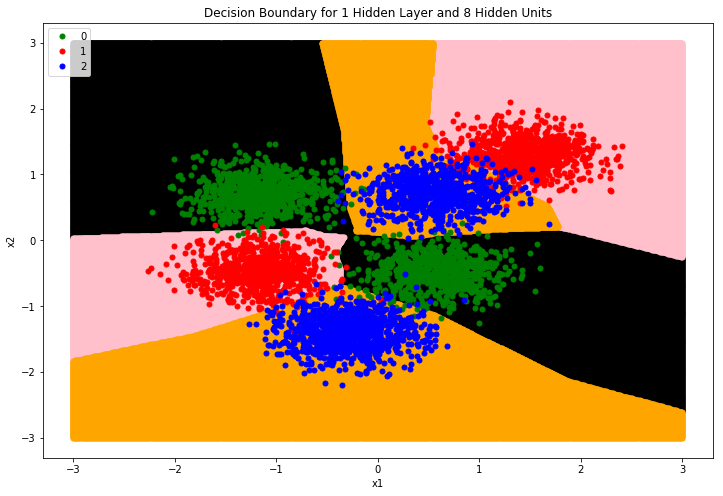

---------------------------------
---------------------------------
Scenario 3
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.0030987529177593344
Epoch: 20, Average Training Loss: 0.002770351201647116
Epoch: 30, Average Training Loss: 0.002664543804465056
Epoch: 40, Average Training Loss: 0.0026112640968039163
Epoch: 50, Average Training Loss: 0.0025794321018917737
Epoch: 60, Average Training Loss: 0.00255687182416229
Epoch: 70, Average Training Loss: 0.002539977764402398
Epoch: 80, Average Training Loss: 0.002528433932262697
Epoch: 90, Average Training Loss: 0.0025192326442564
Epoch: 100, Average Training Loss: 0.002511672339884477


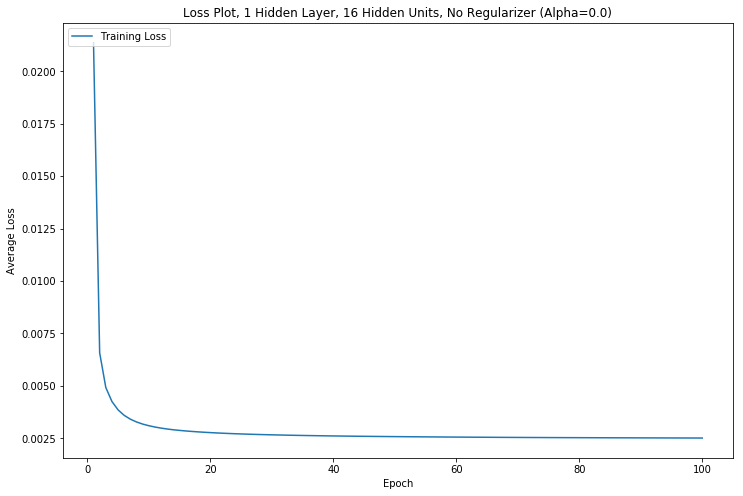

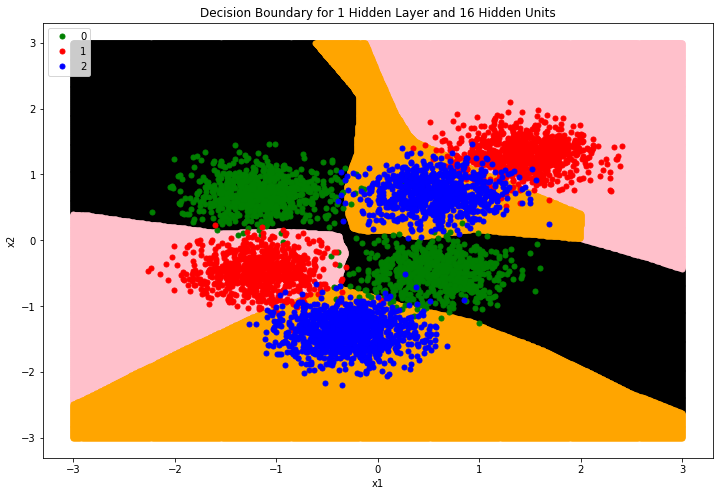

---------------------------------
---------------------------------
Scenario 4
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.031958281608196096
Epoch: 20, Average Training Loss: 0.03147695229952529
Epoch: 30, Average Training Loss: 0.027674884908040223
Epoch: 40, Average Training Loss: 0.02063189022417993
Epoch: 50, Average Training Loss: 0.018481836903404797
Epoch: 60, Average Training Loss: 0.018266963824949623
Epoch: 70, Average Training Loss: 0.017969672442263395
Epoch: 80, Average Training Loss: 0.01725293554808684
Epoch: 90, Average Training Loss: 0.016156517388161526
Epoch: 100, Average Training Loss: 0.015634137442785252


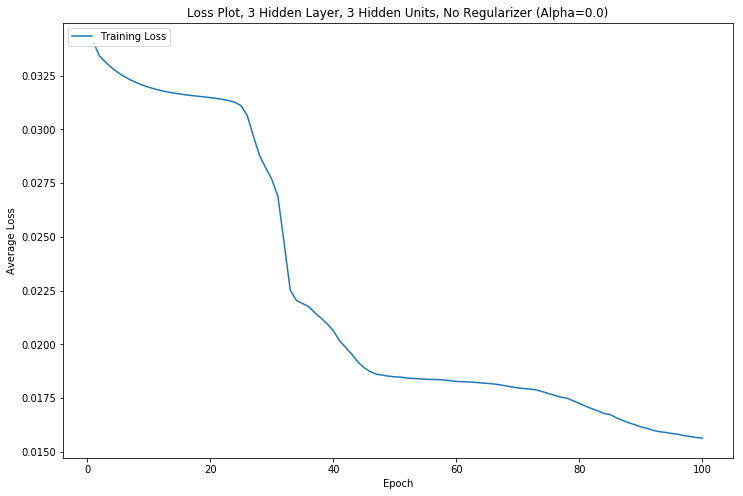

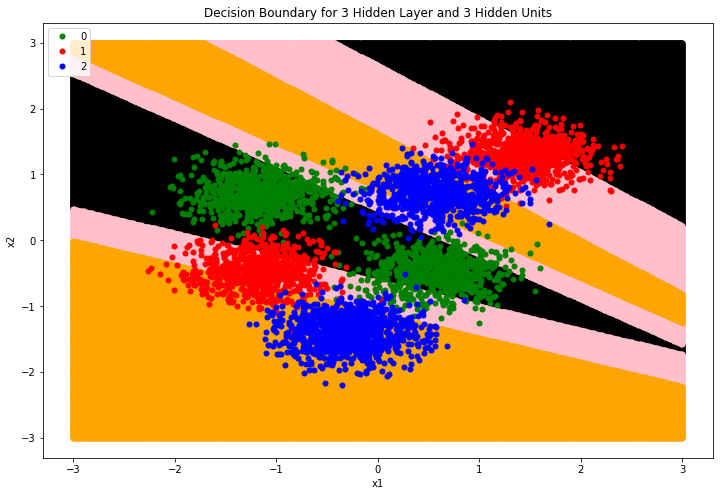

---------------------------------
---------------------------------
Scenario 5
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.004894763528602224
Epoch: 20, Average Training Loss: 0.003810036117303337
Epoch: 30, Average Training Loss: 0.003501575103284314
Epoch: 40, Average Training Loss: 0.0033288390051786658
Epoch: 50, Average Training Loss: 0.0032049838286599425
Epoch: 60, Average Training Loss: 0.00311260608791495
Epoch: 70, Average Training Loss: 0.0030521394385683125
Epoch: 80, Average Training Loss: 0.0030030366250813813
Epoch: 90, Average Training Loss: 0.0029669261658195507
Epoch: 100, Average Training Loss: 0.002936554066926107


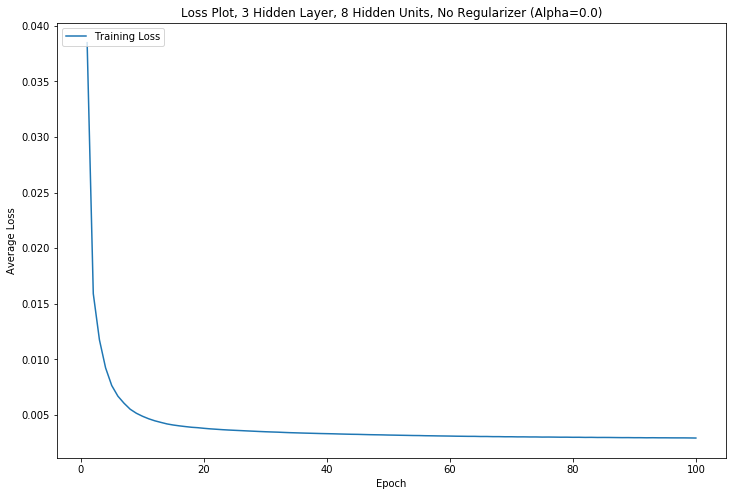

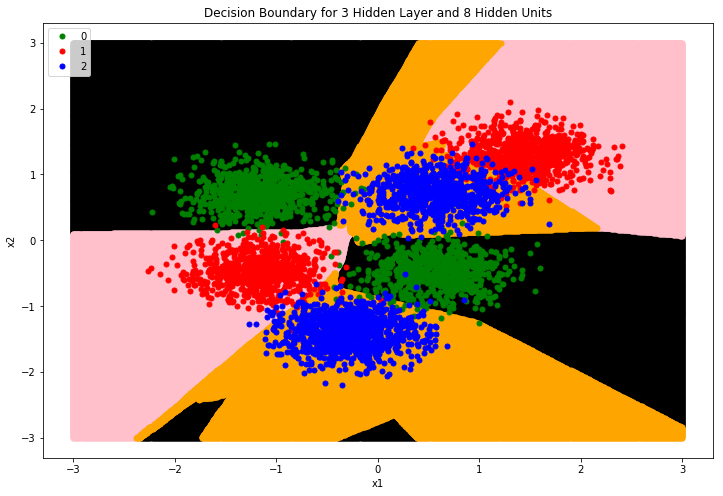

---------------------------------
---------------------------------
Scenario 6
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.003377070147611738
Epoch: 20, Average Training Loss: 0.0030002938632343536
Epoch: 30, Average Training Loss: 0.0028516925640145858
Epoch: 40, Average Training Loss: 0.0027212242270913917
Epoch: 50, Average Training Loss: 0.0026370708460275055
Epoch: 60, Average Training Loss: 0.002572782053515786
Epoch: 70, Average Training Loss: 0.0025549326600472254
Epoch: 80, Average Training Loss: 0.002534423406447187
Epoch: 90, Average Training Loss: 0.002510273507530126
Epoch: 100, Average Training Loss: 0.002489195549368006


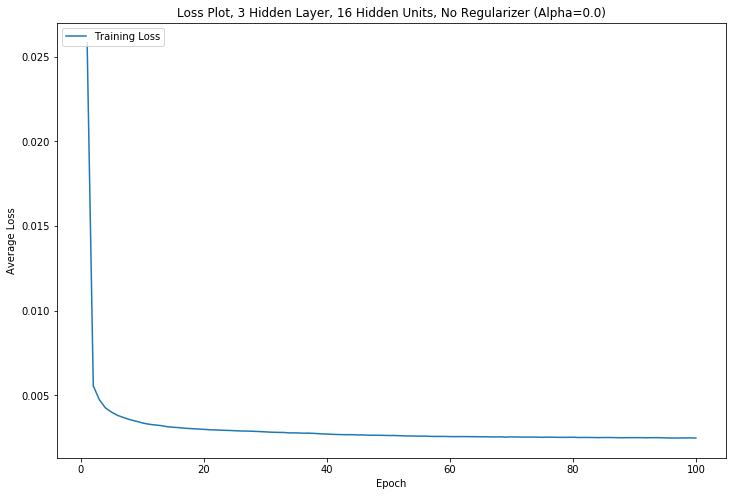

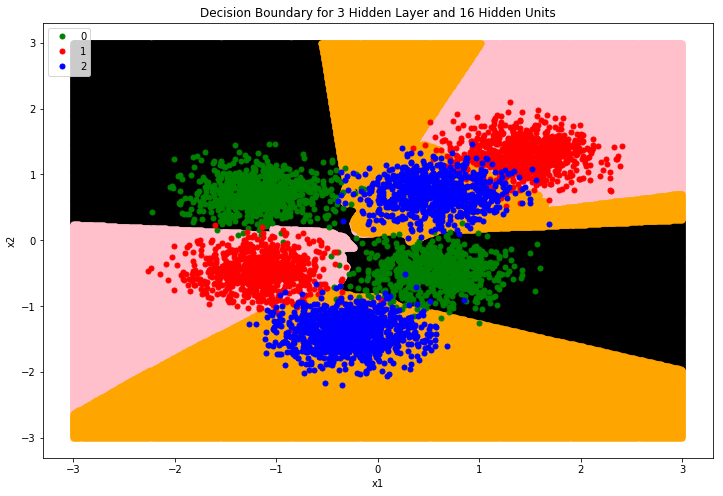

---------------------------------
---------------------------------
Scenario 7
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.0657910113115221
Epoch: 20, Average Training Loss: 0.06729044829849419
Epoch: 30, Average Training Loss: 0.06800932806394268
Epoch: 40, Average Training Loss: 0.06796545597563948
Epoch: 50, Average Training Loss: 0.06748933664024855
Epoch: 60, Average Training Loss: 0.06693449194256357
Epoch: 70, Average Training Loss: 0.06648152812710591
Epoch: 80, Average Training Loss: 0.06629913573288472
Epoch: 90, Average Training Loss: 0.06671170080567713
Epoch: 100, Average Training Loss: 0.06807952949008941


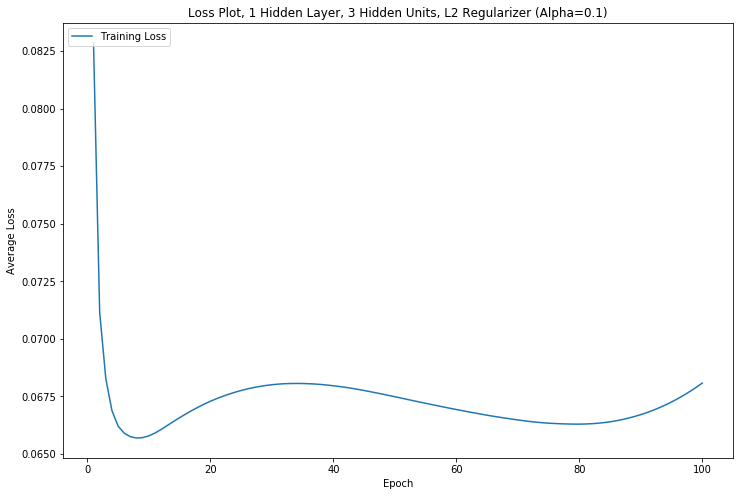

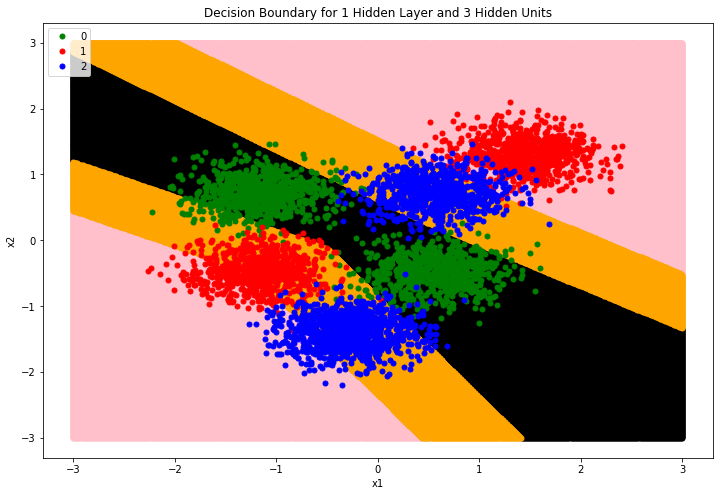

---------------------------------
---------------------------------
Scenario 8
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.18233074686501313
Epoch: 20, Average Training Loss: 0.17785994835770672
Epoch: 30, Average Training Loss: 0.1706930780285786
Epoch: 40, Average Training Loss: 0.16308288807151022
Epoch: 50, Average Training Loss: 0.15570357075032115
Epoch: 60, Average Training Loss: 0.14882293453992804
Epoch: 70, Average Training Loss: 0.14253602612634775
Epoch: 80, Average Training Loss: 0.13681902521708966
Epoch: 90, Average Training Loss: 0.1316510136646022
Epoch: 100, Average Training Loss: 0.1269774522905805


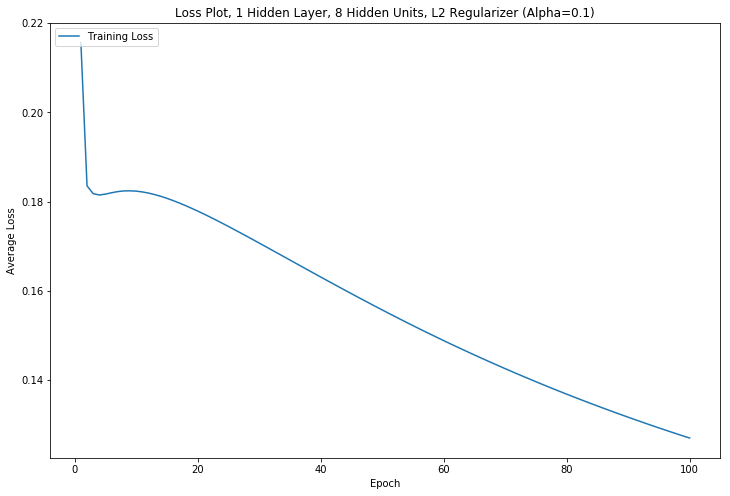

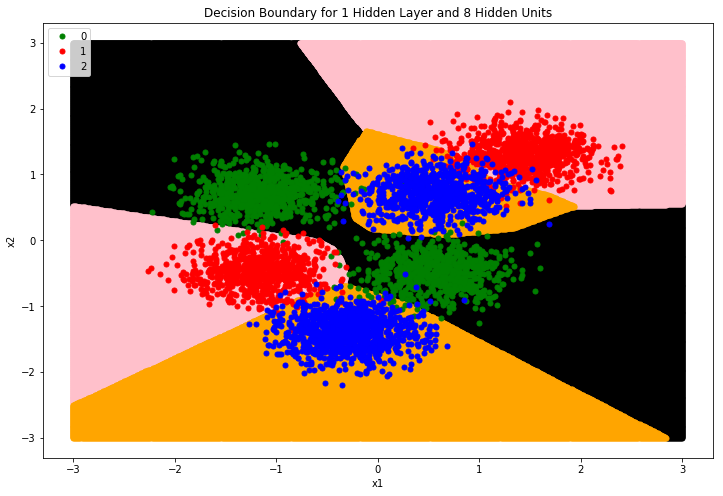

---------------------------------
---------------------------------
Scenario 9
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.45358023999014174
Epoch: 20, Average Training Loss: 0.41622017459923044
Epoch: 30, Average Training Loss: 0.38216555841232996
Epoch: 40, Average Training Loss: 0.35145839045525407
Epoch: 50, Average Training Loss: 0.32388116455022004
Epoch: 60, Average Training Loss: 0.29915825402412427
Epoch: 70, Average Training Loss: 0.276983392373901
Epoch: 80, Average Training Loss: 0.2570399994026027
Epoch: 90, Average Training Loss: 0.23898419202952823
Epoch: 100, Average Training Loss: 0.22257106453855885


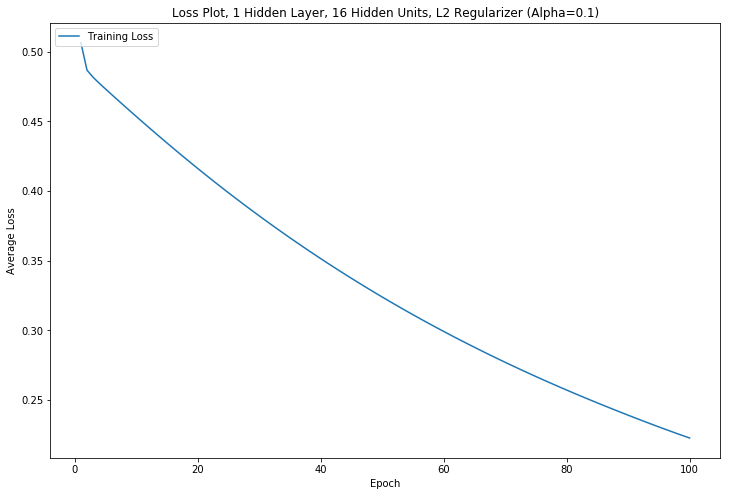

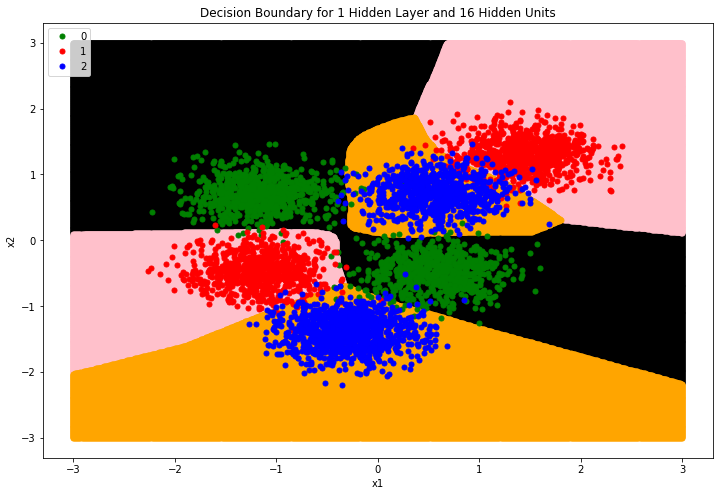

---------------------------------
---------------------------------
Scenario 10
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.08961022608463579
Epoch: 20, Average Training Loss: 0.08435331753180486
Epoch: 30, Average Training Loss: 0.07959666573488078
Epoch: 40, Average Training Loss: 0.07529267631998834
Epoch: 50, Average Training Loss: 0.0713982721913422
Epoch: 60, Average Training Loss: 0.06787447553382378
Epoch: 70, Average Training Loss: 0.06468601782031076
Epoch: 80, Average Training Loss: 0.061800986821382534
Epoch: 90, Average Training Loss: 0.05919050720626919
Epoch: 100, Average Training Loss: 0.05682845153911897


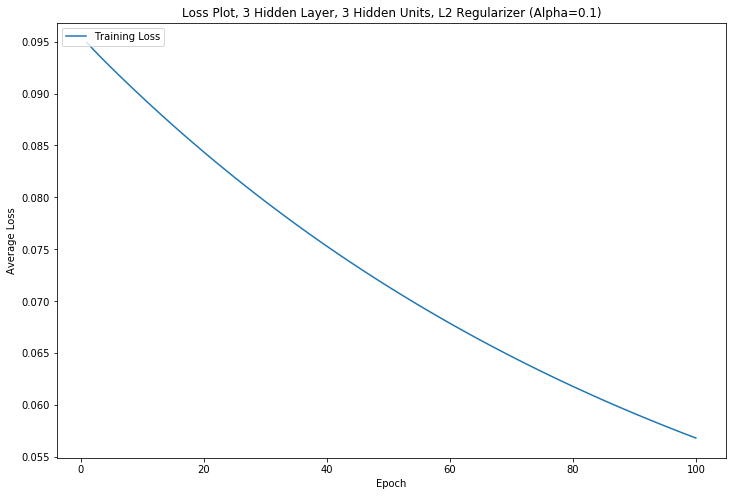

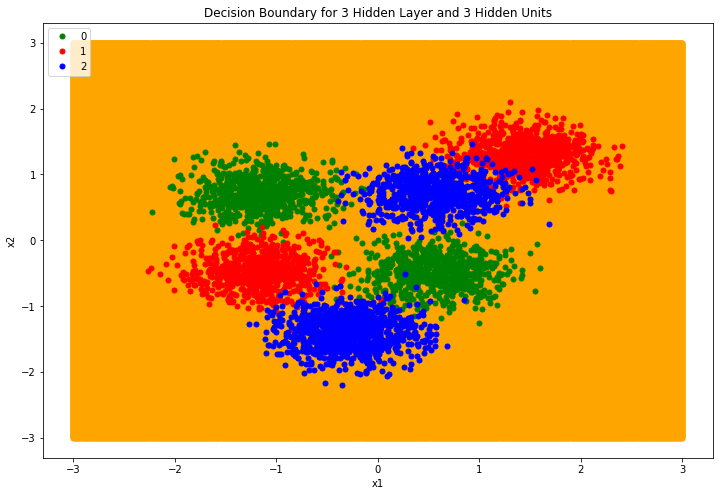

---------------------------------
---------------------------------
Scenario 11
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.36547661145898447
Epoch: 20, Average Training Loss: 0.3361041494878381
Epoch: 30, Average Training Loss: 0.30923498762356455
Epoch: 40, Average Training Loss: 0.28493208745992693
Epoch: 50, Average Training Loss: 0.2632387440464026
Epoch: 60, Average Training Loss: 0.24371357149276623
Epoch: 70, Average Training Loss: 0.22642681649626106
Epoch: 80, Average Training Loss: 0.21086374172336408
Epoch: 90, Average Training Loss: 0.1967481980625861
Epoch: 100, Average Training Loss: 0.18407547705050764


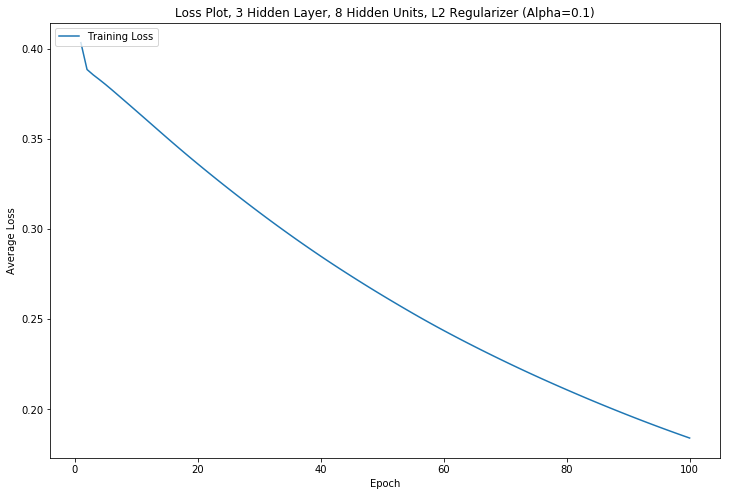

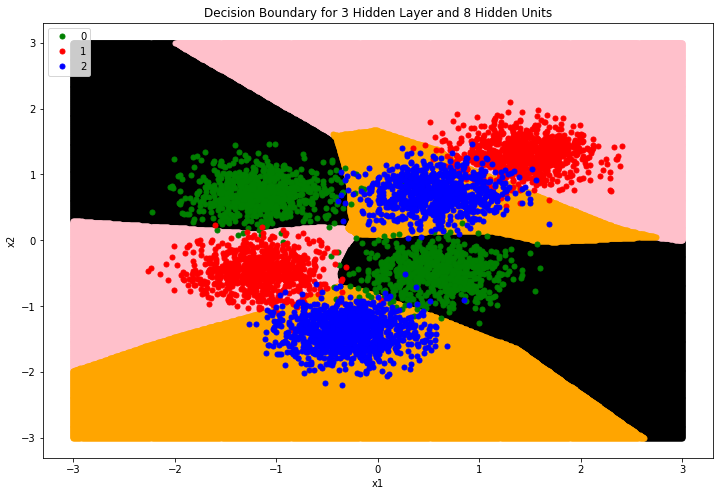

---------------------------------
---------------------------------
Scenario 12
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 1.2159321741291023
Epoch: 20, Average Training Loss: 1.0983274317295104
Epoch: 30, Average Training Loss: 0.9947018708844555
Epoch: 40, Average Training Loss: 0.9024736061493867
Epoch: 50, Average Training Loss: 0.8198601857433109
Epoch: 60, Average Training Loss: 0.7455681598833377
Epoch: 70, Average Training Loss: 0.6786945332815486
Epoch: 80, Average Training Loss: 0.6184896602980218
Epoch: 90, Average Training Loss: 0.5644294989272334
Epoch: 100, Average Training Loss: 0.5157951984702729


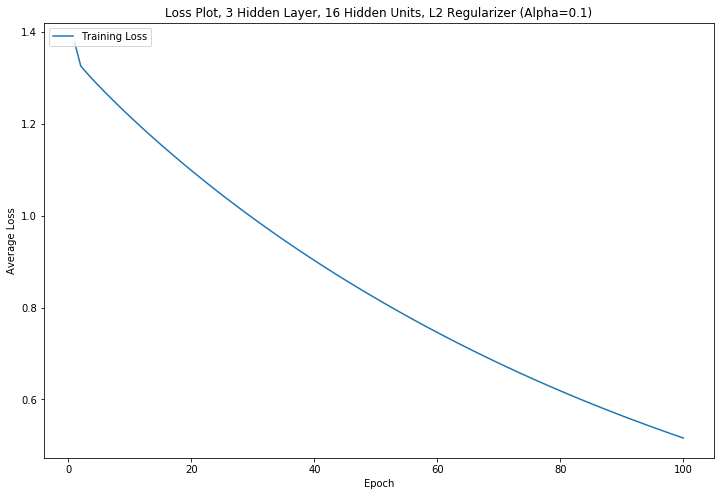

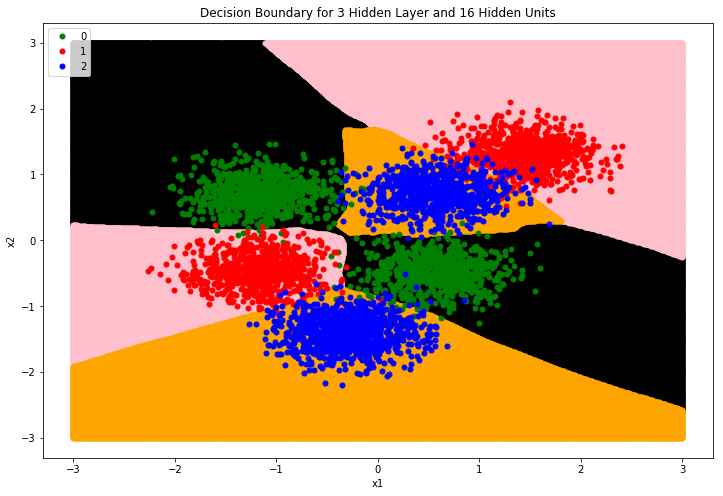

---------------------------------
---------------------------------
Scenario 13
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.2130987582097706
Epoch: 20, Average Training Loss: 0.17541328350353078
Epoch: 30, Average Training Loss: 0.1783324933786455
Epoch: 40, Average Training Loss: 0.1903793952648781
Epoch: 50, Average Training Loss: 0.2206005352495129
Epoch: 60, Average Training Loss: 0.28228869943892143
Epoch: 70, Average Training Loss: 0.30842243673344566
Epoch: 80, Average Training Loss: 0.320543412905932
Epoch: 90, Average Training Loss: 0.3274516290779995
Epoch: 100, Average Training Loss: 0.3314483376264932


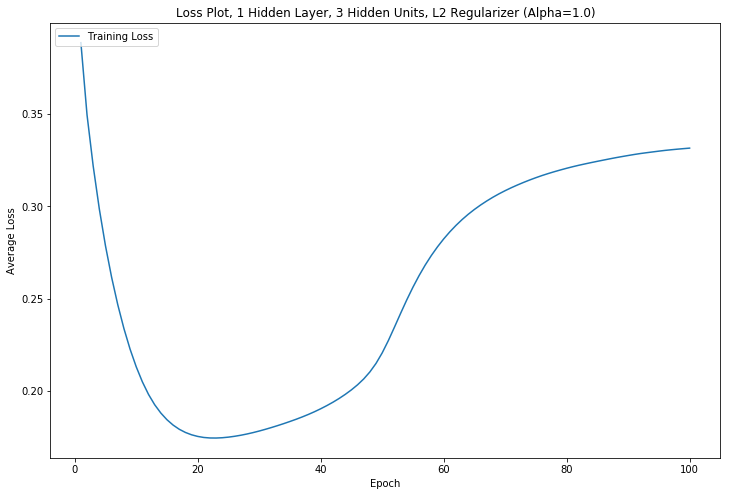

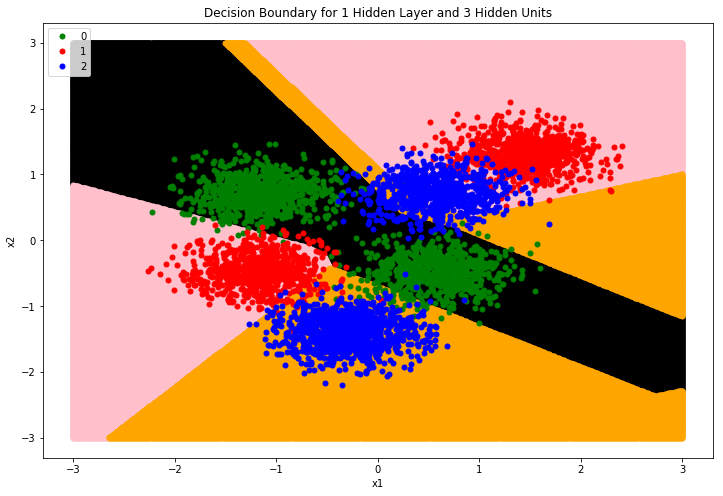

---------------------------------
---------------------------------
Scenario 14
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.7972103098231522
Epoch: 20, Average Training Loss: 0.5187850649119511
Epoch: 30, Average Training Loss: 0.4128920255222373
Epoch: 40, Average Training Loss: 0.3740840476528846
Epoch: 50, Average Training Loss: 0.3614809274032441
Epoch: 60, Average Training Loss: 0.35765599031259243
Epoch: 70, Average Training Loss: 0.3566512513946028
Epoch: 80, Average Training Loss: 0.3567860239883031
Epoch: 90, Average Training Loss: 0.3573354967202357
Epoch: 100, Average Training Loss: 0.3579450061565625


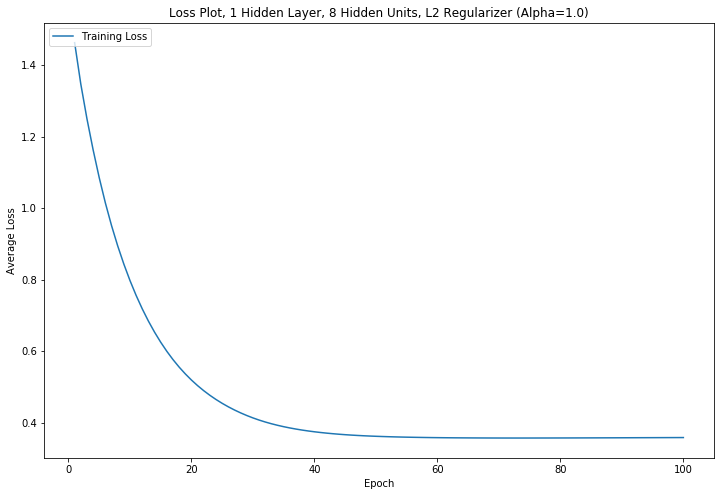

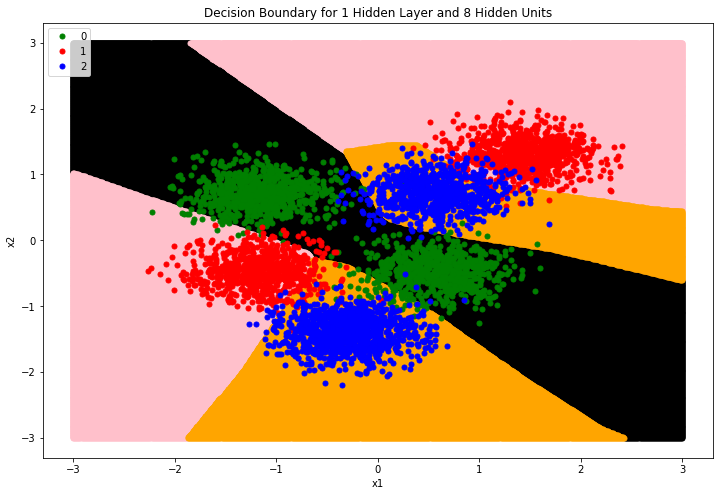

---------------------------------
---------------------------------
Scenario 15
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 2.195676614318527
Epoch: 20, Average Training Loss: 1.0032899474444013
Epoch: 30, Average Training Loss: 0.6080281178540615
Epoch: 40, Average Training Loss: 0.47719651792400747
Epoch: 50, Average Training Loss: 0.4299961299263894
Epoch: 60, Average Training Loss: 0.4098526626808655
Epoch: 70, Average Training Loss: 0.3992164011557062
Epoch: 80, Average Training Loss: 0.3923852003070647
Epoch: 90, Average Training Loss: 0.3871260261835942
Epoch: 100, Average Training Loss: 0.3820931049374935


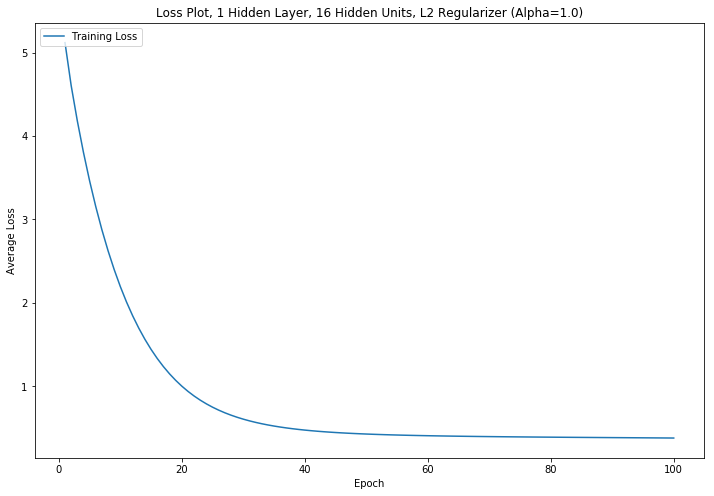

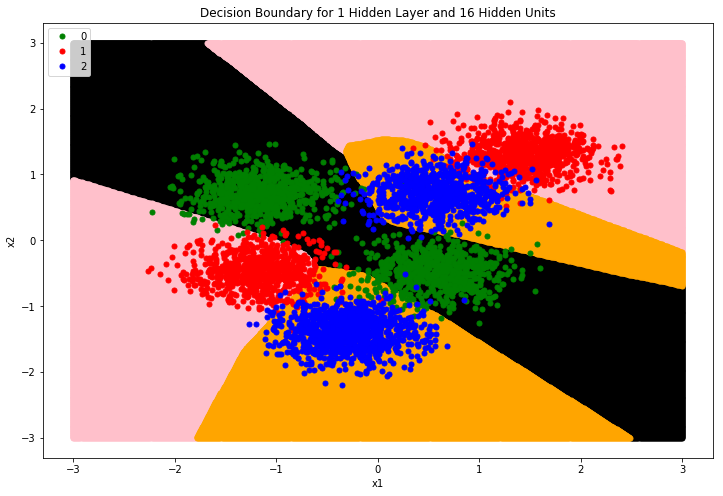

---------------------------------
---------------------------------
Scenario 16
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.3377898024609482
Epoch: 20, Average Training Loss: 0.2588287263442065
Epoch: 30, Average Training Loss: 0.23961550118324754
Epoch: 40, Average Training Loss: 0.2326956319455537
Epoch: 50, Average Training Loss: 0.23039608414926502
Epoch: 60, Average Training Loss: 0.23005412417777488
Epoch: 70, Average Training Loss: 0.23048853192864663
Epoch: 80, Average Training Loss: 0.23099200643027087
Epoch: 90, Average Training Loss: 0.2314526902386962
Epoch: 100, Average Training Loss: 0.23183112676436027


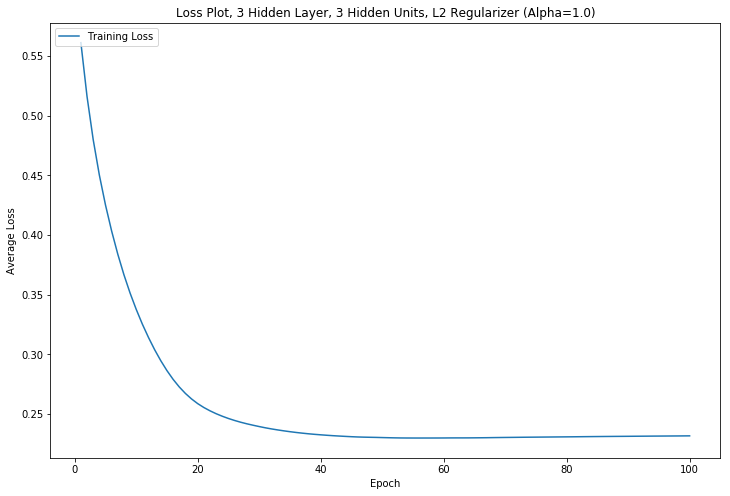

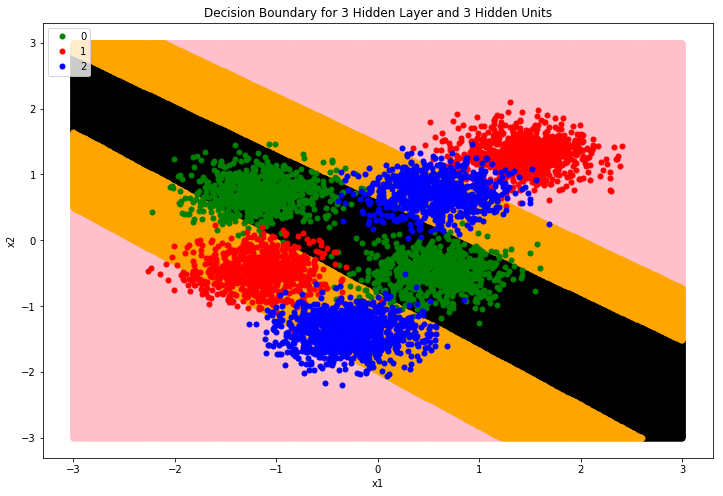

---------------------------------
---------------------------------
Scenario 17
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 1.513800977220711
Epoch: 20, Average Training Loss: 0.8009169606386624
Epoch: 30, Average Training Loss: 0.5628107254482627
Epoch: 40, Average Training Loss: 0.48636478575953795
Epoch: 50, Average Training Loss: 0.458753062780079
Epoch: 60, Average Training Loss: 0.446720219877819
Epoch: 70, Average Training Loss: 0.44092673889714323
Epoch: 80, Average Training Loss: 0.4377726217207781
Epoch: 90, Average Training Loss: 0.43579052498200427
Epoch: 100, Average Training Loss: 0.4344655606388228


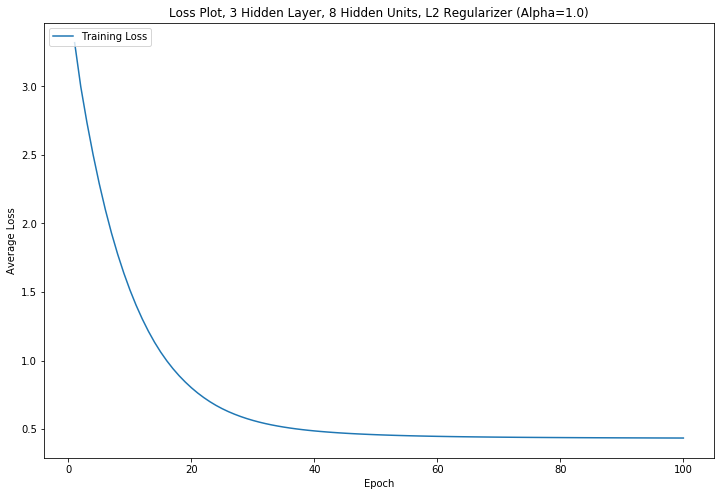

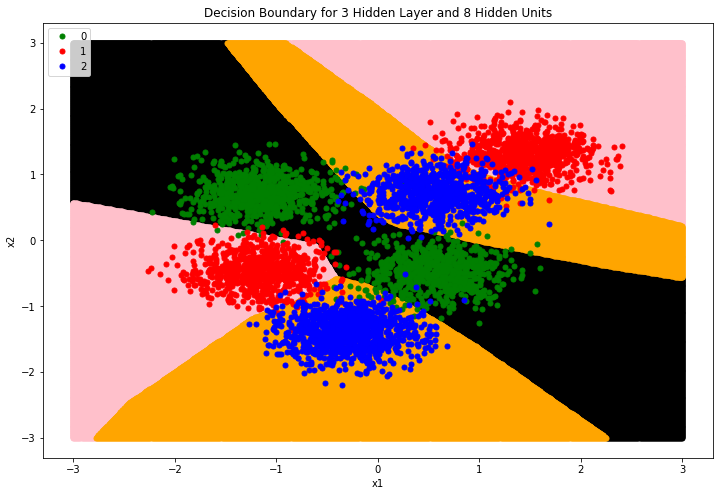

---------------------------------
---------------------------------
Scenario 18
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 5.006479057507097
Epoch: 20, Average Training Loss: 2.0657329720191884
Epoch: 30, Average Training Loss: 1.044500754028364
Epoch: 40, Average Training Loss: 0.6890360862557758
Epoch: 50, Average Training Loss: 0.5613452722643185
Epoch: 60, Average Training Loss: 0.512915981369145
Epoch: 70, Average Training Loss: 0.4926175423320234
Epoch: 80, Average Training Loss: 0.48257157665817585
Epoch: 90, Average Training Loss: 0.4769223383924047
Epoch: 100, Average Training Loss: 0.4732127855651869


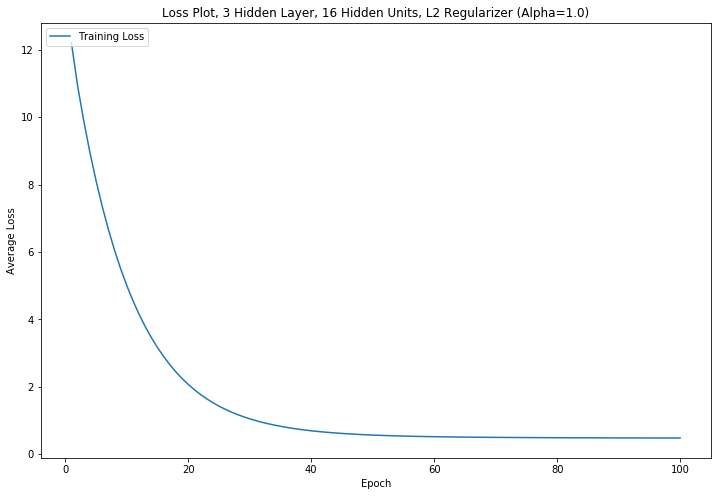

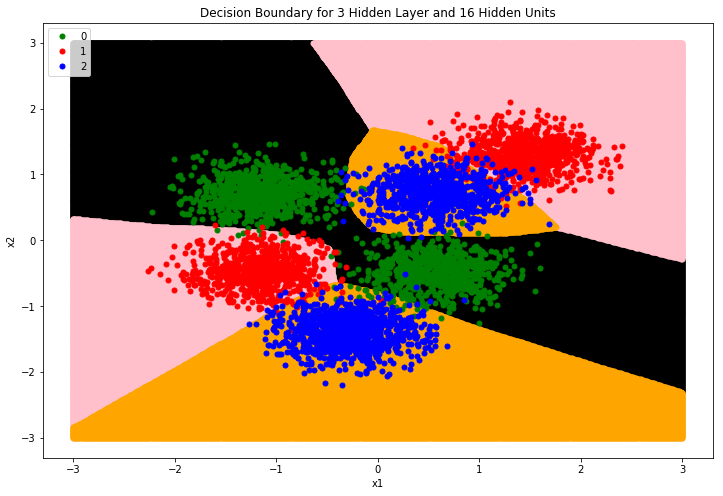

---------------------------------
---------------------------------


In [23]:
scenario = {
    'debug': False,
    'feature_size': 2,
    'n_classes': 3,
    'n_hidden_layers': [1, 3],
    'n_hidden_units': [3, 8, 16],
    'regularizers': [ 
        None, {
            'reg_type': 'L2',
            'alpha': 0.1
        }, {
            'reg_type': 'L2',
            'alpha': 1.0
        } 
    ]
}

do_train(scenario)

### d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your testing data to decide when to stop training if appropriate. Use your validation set to compute the accuracy of you classfier.

#### Data Description

I use image data, taken from `Google`. The classes are `Central Park`, `Time Square` and `Liberty Statue`. Each class has `120` data in total, with `90` of them being the train set, `15` of them being the validation set and the other `15` of them being the test set. This is the same data that I used for `HW1` and `HW2`except that I add a new class `Liberty Statue` and I organize the directory so now it contains `validation` data. In my implementation, `validation` data is used to decide when to stop the training using `Early Stopping` (the detail will be discussed later), meanwhile `test` data is only used `once` at the end to compute the final `accuracy`.

In [24]:
# Uncomment below command if needed, i.e. libraries below are not yet installed
# !pip install matplotlib numpy opencv-python scipy 

In [25]:
!ls "data/train/centralpark" | wc -l
!ls "data/train/timesquare" | wc -l
!ls "data/train/liberty" | wc -l

!ls "data/val/centralpark" | wc -l
!ls "data/val/timesquare" | wc -l
!ls "data/val/liberty" | wc -l

!ls "data/test/centralpark" | wc -l
!ls "data/test/timesquare" | wc -l
!ls "data/test/liberty" | wc -l

      90
      90
      90
      15
      15
      15
      15
      15
      15


#### Imports and Dir Constants

In [26]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.stats import multivariate_normal
from datetime import datetime

base_path        = 'data'
train_path       = base_path + '/train'
val_path         = base_path + '/val'
test_path        = base_path + '/test'

#### Determine Fixed Size

I find that for both train and test data, there is no image with lower resolution than 200x200, so I pick that as my fixed size

In [27]:
def fetch_dim(image, label):
    height, width, channels = image.shape
    return label, height, width

def find_min_size(data_type, threshold):
    # Pick the corresponding path
    if data_type == 'train':
        print('Find in train data ...')
        data_path = train_path
    elif data_type == 'val':
        print('Find in val data ...')
        data_path = val_path
    elif data_type == 'test':
        print('Find in test data ...')
        data_path = test_path
    else:
        raise Exception('Supply "train"/"val"/"test" as param')

    # Get the labels, sorted, in this case it's just ['cats', 'dogs']
    classes = sorted(os.listdir(data_path))

    # Array to store image size
    image_sizes = []

    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)
      
        if not '.DS_Store' in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)
                
                if not '.DS_Store' in image_path:
                    # Calculate size
                    if 'HEIC' not in image_path:
                        image = cv2.imread(image_path)
                        image_sizes.append(fetch_dim(image, label))

    # Return all image sizes that are less than the size threshold
    return [elem for elem in image_sizes if elem[0] == classes[0] and elem[1] < threshold and elem[2] < threshold], [elem for elem in image_sizes if elem[0] == classes[1] and elem[1] < threshold and elem[2] < threshold]

train_min_size = find_min_size('train', 200)
print(len(train_min_size[0]), len(train_min_size[1]))

val_min_size = find_min_size('val', 200)
print(len(val_min_size[0]), len(val_min_size[1]))

test_min_size = find_min_size('test', 200)
print(len(test_min_size[0]), len(test_min_size[1]))

# Set fixed_size constant
fixed_size = tuple([200, 200])

Find in train data ...
0 0
Find in val data ...
0 0
Find in test data ...
0 0


#### Feature Extractor Function

I use Color Histogram from OpenCV as my feature, with the following detail:
1. Using three channels (RGB), denoted by [0 1 2]
2. The color range is default, 0 to 256
3. There are 8 bins (I handpick this, no particular reason).

The above scenario results in a feature vector of size 512.

In [28]:
bins = 8

# Color Histogram Feature
# a. Convert the image to HSV color-space
# b. Compute the color histogram
# c. Normalize the histogram
def compute_histogram(image, mask=None):
    hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2HSV)], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

#### Precompute the Features for Train and Test Data

In [29]:
image_sizes = []

def precompute_features(data_type, is_timed):
    if is_timed:
        start = datetime.now()

    # Pick the corresponding path
    if data_type == 'train':
        print('Precomputing train data features...')
        data_path = train_path
    elif data_type == 'val':
        print('Precomputing validation data features...')
        data_path = val_path
    elif data_type == 'test':
        print('Precomputing test data features...')
        data_path = test_path
    else:
        raise Exception('Supply "train"/"val"/"test" as param')

    # Placeholder for returned features and labels
    features = []
    labels = []

    # Get the labels, sorted, in this case it's ['centralpark', 'timesquare']
    classes = sorted(os.listdir(data_path))
    
    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)

        if not '.DS_Store' in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)

                # Resize image, refer to the previous constant
                if not 'HEIC' in image_path and not '.DS_Store' in image_path:
                    image = cv2.imread(image_path)
                    image_sizes.append(fetch_dim(image, label))
                    image = cv2.resize(image, fixed_size)

                    # Extract three different features
                    hist = compute_histogram(image) 
                    # print(hist.shape) #(512, )

                    # Append to placeholder
                    features.append(hist)
                    labels.append(label)

            print("Time elapsed: {}".format(datetime.now() - start)) 
            print("Processed dir: {}".format(label))
    
    return np.array(features), labels

train_features, train_labels = precompute_features('train', True)
print('--------------------')
val_features, val_labels = precompute_features('val', True)
print('--------------------')
test_features, test_labels = precompute_features('test', True)
print('--------------------')

assert train_features.shape == (270, 512)
assert val_features.shape == (45, 512)
assert test_features.shape == (45, 512)

assert len(train_labels) == 270
assert len(val_features) == 45
assert len(test_labels) == 45
print('--------------------')

Precomputing train data features...
Time elapsed: 0:00:00.160180
Processed dir: centralpark
Time elapsed: 0:00:00.311321
Processed dir: liberty
Time elapsed: 0:00:00.496349
Processed dir: timesquare
--------------------
Precomputing validation data features...
Time elapsed: 0:00:00.026002
Processed dir: centralpark
Time elapsed: 0:00:00.049172
Processed dir: liberty
Time elapsed: 0:00:00.079547
Processed dir: timesquare
--------------------
Precomputing test data features...
Time elapsed: 0:00:00.025371
Processed dir: centralpark
Time elapsed: 0:00:00.048742
Processed dir: liberty
Time elapsed: 0:00:00.078255
Processed dir: timesquare
--------------------
--------------------


Convert the `512` sized vector into a vector of size `2` using the method I've mentioned before.

In [30]:
feature_dim = len(train_features[0])

assert feature_dim == 512

# Take the features from the train set
train_hist_1 = train_features[:, 0:(feature_dim//2)]
train_hist_2 = train_features[:, (feature_dim//2):feature_dim]

assert train_hist_1.shape == (270, 256)
assert train_hist_2.shape == (270, 256)

# Take the average of those features
train_avg_hist_1 = train_hist_1.mean(axis=1)
train_avg_hist_2 = train_hist_2.mean(axis=1)

assert train_avg_hist_1.shape == (270,)
assert train_avg_hist_2.shape == (270,)

# Take the features from the validation set
val_hist_1 = val_features[:, 0:(feature_dim//2)]
val_hist_2 = val_features[:, (feature_dim//2):feature_dim]

assert val_hist_1.shape == (45, 256)
assert val_hist_2.shape == (45, 256)

# Take the average of those features
val_avg_hist_1 = val_hist_1.mean(axis=1)
val_avg_hist_2 = val_hist_2.mean(axis=1)

assert val_avg_hist_1.shape == (45,)
assert val_avg_hist_2.shape == (45,)

# Take the features from the test set
test_hist_1 = test_features[:, 0:(feature_dim//2)]
test_hist_2 = test_features[:, (feature_dim//2):feature_dim]

assert test_hist_1.shape == (45, 256)
assert test_hist_2.shape == (45, 256)

# Take the average of those features
test_avg_hist_1 = test_hist_1.mean(axis=1)
test_avg_hist_2 = test_hist_2.mean(axis=1)

assert test_avg_hist_1.shape == (45,)
assert test_avg_hist_2.shape == (45,)

In [31]:
# Zip the two train_avg_hist features to build X
X_train = np.dstack((train_avg_hist_1, train_avg_hist_2))[0]
X_val = np.dstack((val_avg_hist_1, val_avg_hist_2))[0]
X_test = np.dstack((test_avg_hist_1, test_avg_hist_2))[0]

Convert `X` and `y` into `np.array`

In [32]:
# Convert string label to numeric, 'centralpark' as 0 and 'timesquare' as 1
y_train_image = np.array([0.0 if label == 'centralpark' else 1.0 if label == 'timesquare' else 2.0 for label in train_labels])
y_val_image = np.array([0.0 if label == 'centralpark' else 1.0 if label == 'timesquare' else 2.0 for label in val_labels])
y_test_image = np.array([0.0 if label == 'centralpark' else 1.0 if label == 'timesquare' else 2.0 for label in test_labels])

# X_train = np.array(train_features)
y_train = np.array(y_train_image)[:, np.newaxis]

# X_val = np.array(val_features)
y_val = np.array(y_val_image)[:, np.newaxis]

# X_test = np.array(test_features)
y_test = np.array(y_test_image)[:, np.newaxis]

print(X_train.shape)
print(X_train[0:3])

print(X_val.shape)
print(X_val[0:3])

print(X_test.shape)
print(X_test[0:3])

print(y_train.shape)
print(y_train[0])
print(y_train[128])
print(y_train[200])

print(y_val.shape)
print(y_val[0])
print(y_val[28])
print(y_val[40])

print(y_test.shape)
print(y_test[0])
print(y_test[28])
print(y_test[40])

(270, 2)
[[2.1736626e-02 1.2296016e-04]
 [2.1444283e-02 2.9706920e-03]
 [2.0862896e-02 8.4312516e-05]]
(45, 2)
[[2.5549136e-02 4.9563842e-03]
 [1.9321218e-02 4.3085580e-05]
 [2.4927389e-02 1.1800565e-03]]
(45, 2)
[[0.02819582 0.00012034]
 [0.02344674 0.00024521]
 [0.02328073 0.00115906]]
(270, 1)
[0.]
[2.]
[1.]
(45, 1)
[0.]
[2.]
[1.]
(45, 1)
[0.]
[2.]
[1.]


Apply `one hot encoding` to `y`, do sanity check by comparing the `y` printed above

In [33]:
# y_train
data_train = np.array(y_train_image.flatten(), dtype='int32')
shape_train = (data_train.size, int(data_train.max() + 1))

y_train = np.zeros(shape_train)
rows_train = np.arange(data_train.size)

y_train[rows_train, data_train] = 1.0

# y_val
data_val = np.array(y_val_image.flatten(), dtype='int32')
shape_val = (data_val.size, int(data_val.max() + 1))

y_val = np.zeros(shape_val)
rows_val = np.arange(data_val.size)

y_val[rows_val, data_val] = 1.0

# y_test
data_test = np.array(y_test_image.flatten(), dtype='int32')
shape_test = (data_test.size, int(data_test.max() + 1))

y_test = np.zeros(shape_test)
rows_test = np.arange(data_test.size)

y_test[rows_test, data_test] = 1.0

print(y_train.shape)
print(y_train[0])
print(y_train[128])
print(y_train[200])

print(y_val.shape)
print(y_val[0])
print(y_val[28])
print(y_val[40])

print(y_test.shape)
print(y_test[0])
print(y_test[28])
print(y_test[40])

(270, 3)
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
(45, 3)
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
(45, 3)
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]


#### Train with Early Stopping Scenario

Train using $2$ hidden layers and $128$ hidden units. Use `Softmax Cross Entropy` loss. Set `learning rate` to $0.001$ and `number of epochs` to $1000$. Set `minibatch size` to $8$. `Early Stopping` is set to `100`, meaning that if after `100` epochs the validation loss doesn't improve from when we recorded the latest minimum validation loss , i.e. it is still greater than the latest minimum validation loss recorded so far, then we stop the training since there is a very small chance of getting validation loss lower than the latest minimum anymore. Also, at the end of the training, we will retain the weights that are associated with the minimum validation loss instead of taking the latest weights.

In [41]:
feature_size, n_classes = (2, 3)

# Use 1 Hidden Layer with 512 Units
n_hidden_layers, n_hidden_units = (2, 128)

NN = MLP(debug=False)

NN.add_layer('Input', dim_in=feature_size, dim_out=n_hidden_units)
# For this one, I use Leaky ReLU instead of ReLU
# I find that using Leaky ReLU leads to better convergence for this dataset somehow
NN.add_layer('Activation_Leaky_Relu')

# Use 2 Hidden Layers
for _ in range(0, n_hidden_layers):
    NN.add_layer('Hidden', dim_in=n_hidden_units, dim_out=n_hidden_units)
    NN.add_layer('Activation_Leaky_Relu')

NN.add_layer('Output', dim_in=n_hidden_units, dim_out=n_classes)
NN.add_layer('Activation_Softmax')

NN.add_layer('Loss_Cross_Entropy')

print('Training for {} hidden layer(s) and {} hidden units'.format(n_hidden_layers, n_hidden_units))
print('---------------------------------')

# LEARNING_RATE = 0.001 (bigger LEARNING_RATE causes the loss to be jumpy) 
# and BSIZE=8 since the number of data is very small (~200)
# Thus, for every epoch, there will be ~25 minibatches
# EPOCHS is set to 1000 since LEARNING_RATE is very small
# Supply X_val and y_val and also Apply EARLY_STOPPING
min_NN, losses, val_losses = NN.train(X_train, y_train, learning_rate=0.001, epochs=1000, bsize=8, regularizer=None, X_val=X_val, y_val=y_val, early_stopping=100)

Training for 2 hidden layer(s) and 128 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.1544478556570302, Average Validation Loss: 0.3229652372039822
Epoch: 20, Average Training Loss: 0.12131010893002643, Average Validation Loss: 0.33057122490104934
Epoch: 30, Average Training Loss: 0.09479923999251032, Average Validation Loss: 0.24495570083161877
Epoch: 40, Average Training Loss: 0.09508117889191896, Average Validation Loss: 0.19046954935812535
Epoch: 50, Average Training Loss: 0.07179828612245441, Average Validation Loss: 0.12752951604525756
Epoch: 60, Average Training Loss: 0.08044411086157834, Average Validation Loss: 0.17304709705674545
Epoch: 70, Average Training Loss: 0.06699296497396945, Average Validation Loss: 0.15265855929259098
Epoch: 80, Average Training Loss: 0.0663821472255871, Average Validation Loss: 0.10213411274874887
Epoch: 90, Average Training Loss: 0.06957285611339424, Average Validation Loss: 0.11827057027452244
Epoch: 100, Avera

We can see above that instead of stopping at Epoch `1000`, the training process stops at Epoch `215`. This means that we retain the weights we get from Epoch `115` where our latest minimum validation loss lies.

In [42]:
def plot_both_losses(losses, val_losses, title):
    n_iters = len(losses)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.plot(np.arange(1, n_iters + 1, 1), losses, label='Training Loss')
    ax.plot(np.arange(1, n_iters + 1, 1), val_losses, label='Validation Loss')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Loss')
    
    ax.set_title(title)
    
    plt.show()

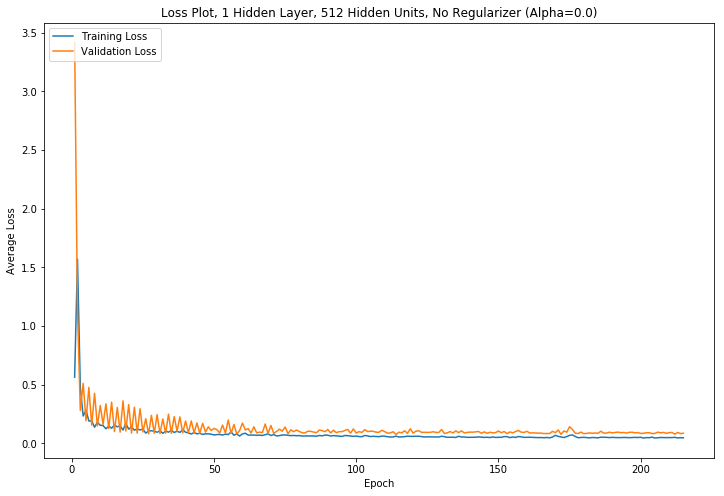

In [43]:
plot_both_losses(losses, val_losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(1, 512, 0.0))

We can see from the plot loss above that the validation loss is stable starting from around Epoch `100`. Thus, I guess that my `Early Stopping` strategy is suitable since there is no point continuing the training if the validation loss won't decrease anymore.

Finally, compute the `test accuracy`. 

In [44]:
NN.compute_accuracy(X_test, y_test)

0.3333333333333333

I got a poor `test accuracy`, $0.33$, which is basically no better than random prediction out of three classes

In [45]:
NN.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

After I check my prediction label above, it turns out that all predicted labels are `Class 1`, i.e. `Times Square`. I've debugged that and found that there is nothing wrong with the outputted `Softmax Probabilities` and how I take the `argmax` from them, i.e. indeed for all test examples, the biggest probability outputted by my NN is for `Class 1`, i.e. the `2nd` index for each row has the highest probabilities. In fact, most of them are very convincing, i.e. the outputted probability is around $0.9$. I haven't been able to solve this issue so far. 